In [1]:
%matplotlib inline

In [2]:
!pip install torchsummary
from torchsummary import summary

In [3]:
from models import *
from utils import *
from data_loaders import *
from train import *
import validation as test
from graph import *

Inside testi////


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
BATCH_SIZE = 128
EPOCHS = 2
device = getDevice()
dataloader_args = getDataLoaderArgs(BATCH_SIZE)
trainloader = getTrainDataLoader(dataloader_args)
testloader = getTestDataLoader(dataloader_args)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))
optimizer = getOptimizer(model)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,728
             ReLU-10          [-1, 128, 32, 32]               0
   GhostBatchNorm-11          [-1, 128, 32, 32]             256
          Dropout-12          [-1, 128, 32, 32]               0
      

In [8]:
for epoch in range(EPOCHS):
  train(model, device, trainloader, optimizer)
  test.__test(model, device, testloader)

Loss=1.451897382736206 Batch_id=390 Accuracy=31.51: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.9278, Accuracy: 3028/10000 (30.28%)



Loss=1.2834157943725586 Batch_id=390 Accuracy=46.61: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]



Test set: Average loss: 1.5258, Accuracy: 4531/10000 (45.31%)



In [11]:
torch.save(model.state_dict(), "./savedModels/cifar.pt")

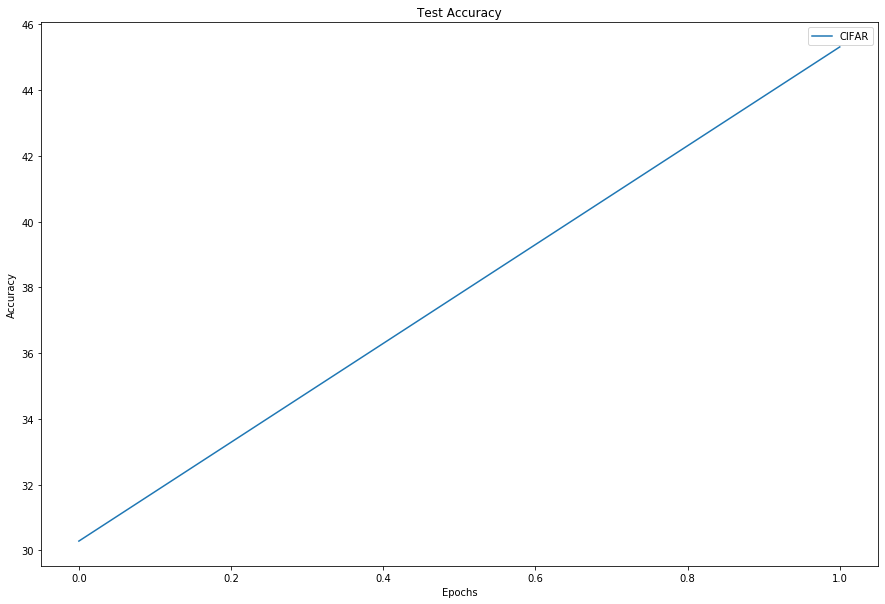

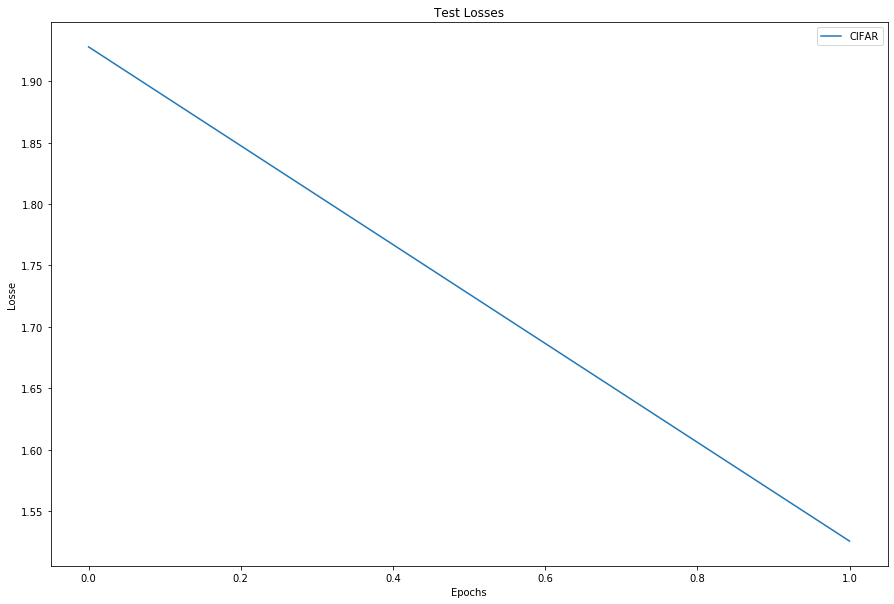

In [9]:
all_test_acc = {'CIFAR':test_acc}
plotGraph(all_test_acc, "Test Accuracy","Epochs", "Accuracy")
all_test_loss = {'CIFAR':test_losses}
plotGraph(all_test_loss, "Test Losses","Epochs", "Losse")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

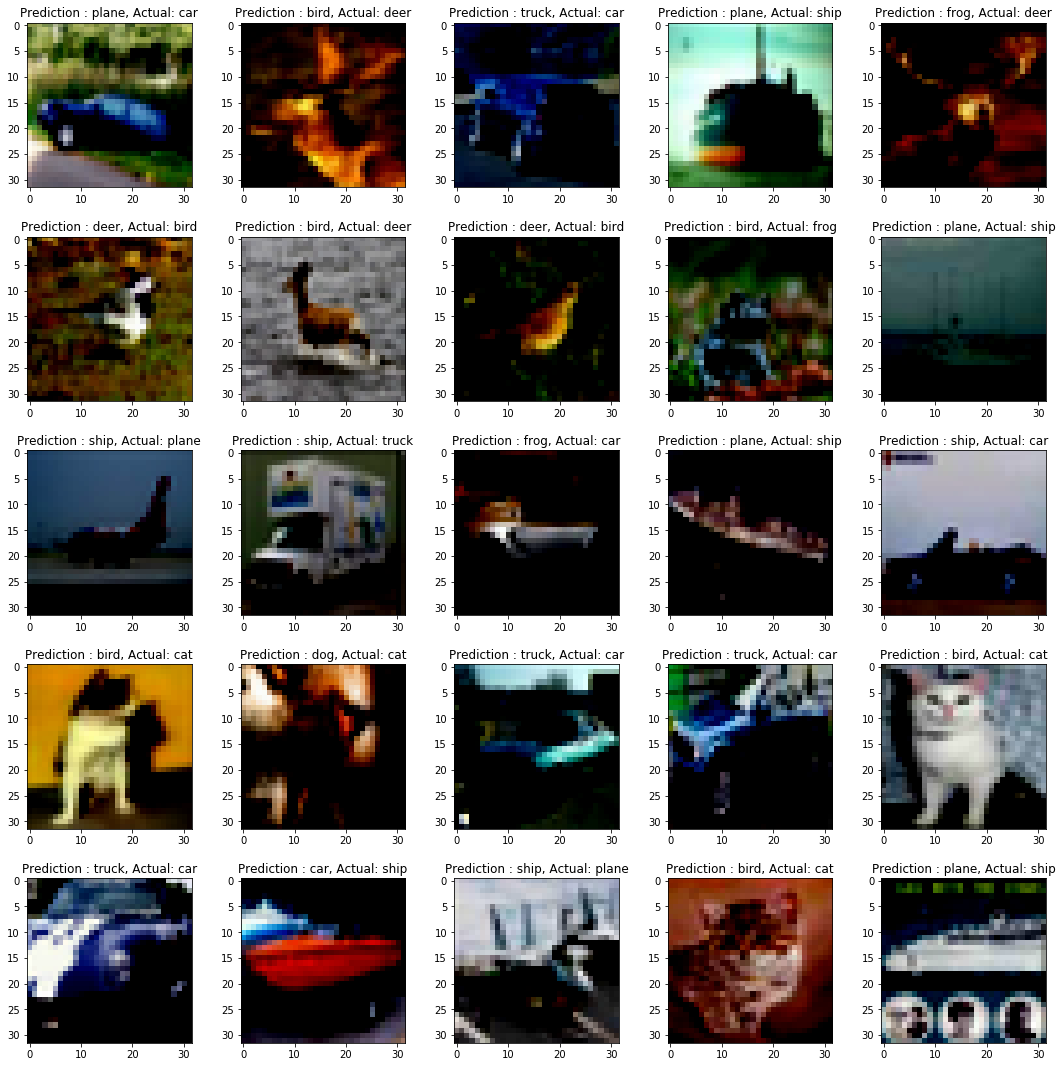

In [5]:
getMisclassifiedImages(Net(), testloader, device, 'savedModels/cifar.pt', classes)